# Model complexity, context specification and assembly policies
In this notebook we explore the effects of specified conditions on Agents (e.g. bound conditions, modification conditions)  and assembly policies on the combinatorial complexity of dynamical models.

First, we import INDRA's TRIPS input API and PySB model assembler.

In [1]:
from indra.sources import trips
from indra.assemblers.pysb import PysbAssembler

# Below is some bookkeeping code needed to display reaction network graphs
%matplotlib inline
from pysb.tools import render_reactions
import pygraphviz, subprocess
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def draw_reaction_network(model):
    pygraphviz.AGraph(render_reactions.run(model)).draw('model.png', prog='dot')
    img = mpimg.imread('model.png')
    plt.figure(figsize=(50, 50))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

## Model1: RAF to ERK without specifying agent context
In the first case, two binding events and a phosphorylation is described with no additional context specified on any of the proteins.

In [2]:
tp = trips.process_text('RAF binds Vemurafenib, RAF phosphorylates MEK and MEK phosphorylates ERK.')

This yields 3 INDRA Statements, as follows. Here empty parentheses after the Agent names indicate that there is no additional context specified on them.

In [3]:
tp.statements

[Complex(RAF(), VEMURAFENIB()),
 Phosphorylation(RAF(), MEK()),
 Phosphorylation(MEK(), ERK())]

### Assembly with one-step policy
We now assemble this model using the default `one_step` policy and store it in the `model1_one` variable.

In [4]:
pa = PysbAssembler()
pa.add_statements(tp.statements)
pa.make_model(policies='one_step')

<Model 'None' (monomers: 4, rules: 4, parameters: 8, expressions: 0, compartments: 0) at 0x1216fa5f8>

In [5]:
model1_one = pa.model

The model has 4 Monomers and 4 Rules.

In [6]:
model1_one.monomers

ComponentSet([
 Monomer('MEK', ['phospho'], {'phospho': ['u', 'p']}),
 Monomer('ERK', ['phospho'], {'phospho': ['u', 'p']}),
 Monomer('RAF', ['vemurafenib']),
 Monomer('VEMURAFENIB', ['map3k']),
 ])

In [7]:
model1_one.rules

ComponentSet([
 Rule('RAF_VEMURAFENIB_bind', RAF(vemurafenib=None) + VEMURAFENIB(map3k=None) >> RAF(vemurafenib=1) % VEMURAFENIB(map3k=1), kf_rv_bind_1),
 Rule('RAF_VEMURAFENIB_dissociate', RAF(vemurafenib=1) % VEMURAFENIB(map3k=1) >> RAF(vemurafenib=None) + VEMURAFENIB(map3k=None), kr_rv_bind_1),
 Rule('RAF_phosphorylation_MEK_phospho', RAF() + MEK(phospho='u') >> RAF() + MEK(phospho='p'), kf_rm_phosphorylation_1),
 Rule('MEK_phosphorylation_ERK_phospho', MEK() + ERK(phospho='u') >> MEK() + ERK(phospho='p'), kf_me_phosphorylation_1),
 ])

Let's examine the last rule which corresponds to MEK phosphorylating ERK. Here, `MEK()` appears without additional context specified. This means that the rule will apply to **any** form of `MEK`, for instance, MEK that is unphosphorylated. 

We now generate the rule-based model into a reaction network form using PySB's interface to BioNetGen.

In [8]:
from pysb.bng import generate_equations
generate_equations(model1_one)

We can now plot the reaction network to examine the model. Each colored node of the reaction network is a molecular species, reactions are represented by gray nodes, and arrows show species being consumed and produced by each reaction.

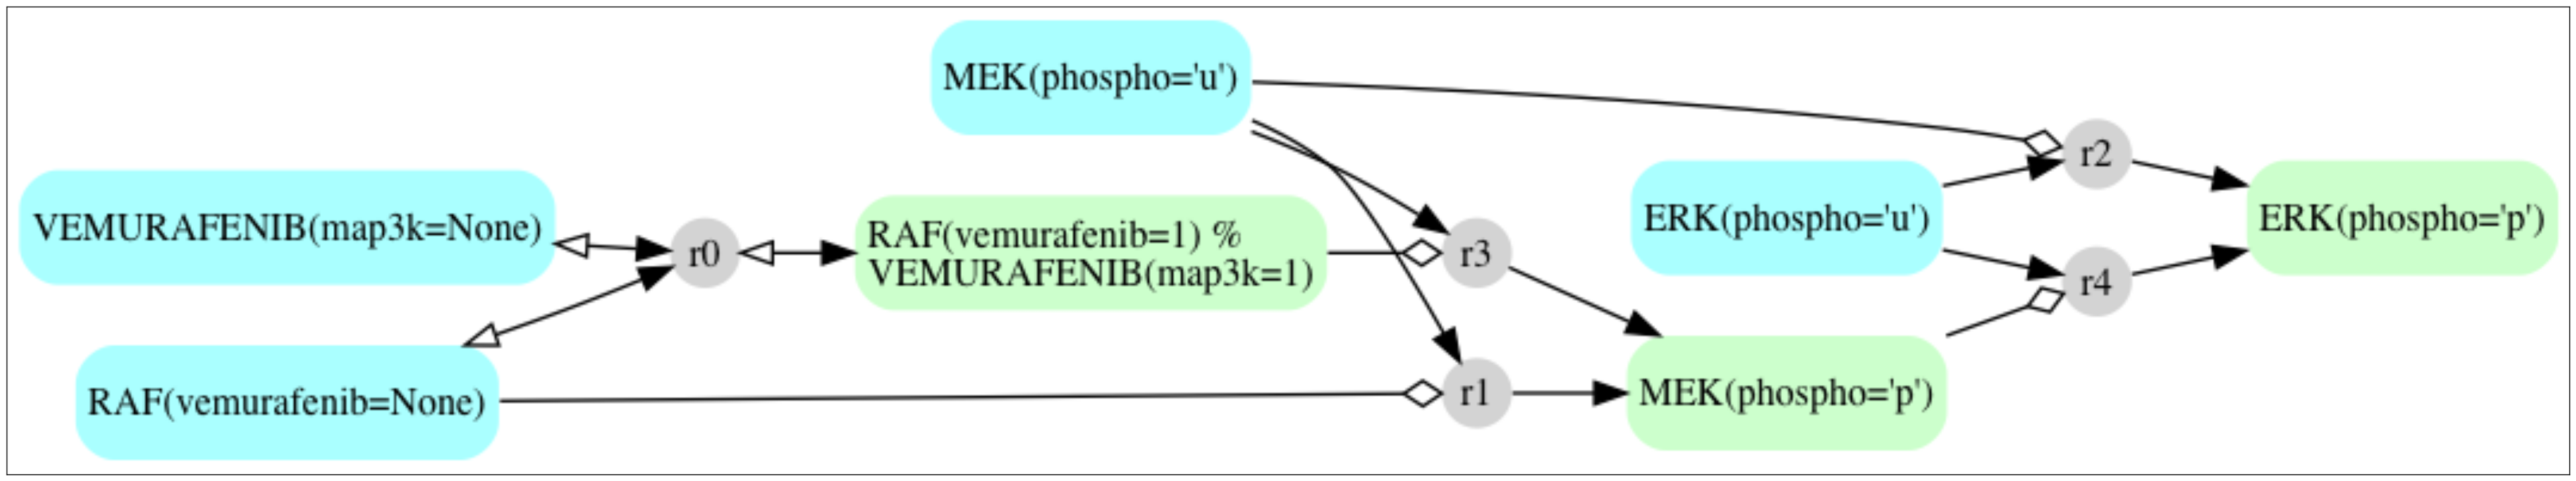

In [9]:
draw_reaction_network(model1_one)

We see from the reaction network that RAF is able to phosphorylate MEK whether or not it is bound to Vemurafenib, and MEK phosphorylates ERK whether or not it is phosphorylated. 

### Assembly with two-step policy
Let's now assemble the same model with the `two-step` policy. This will result in a more detailed model in which MEK first binds ERK reversibly, and phosphorylated ERK is released from the MEK-ERK complex. We will store this model in the `model1_two` variable.

In [10]:
pa.make_model(policies='two_step')

<Model 'None' (monomers: 4, rules: 8, parameters: 12, expressions: 0, compartments: 0) at 0x1216fa630>

In [11]:
model1_two = pa.model

In [12]:
model1_two.monomers

ComponentSet([
 Monomer('MEK', ['phospho', 'map3k', 'mapk'], {'phospho': ['u', 'p']}),
 Monomer('ERK', ['phospho', 'map2k'], {'phospho': ['u', 'p']}),
 Monomer('RAF', ['vemurafenib', 'map2k']),
 Monomer('VEMURAFENIB', ['map3k']),
 ])

In [13]:
for rule in model1_two.rules:
    print(rule.rule_expression)

RAF(vemurafenib=None) + VEMURAFENIB(map3k=None) >> RAF(vemurafenib=1) % VEMURAFENIB(map3k=1)
RAF(vemurafenib=1) % VEMURAFENIB(map3k=1) >> RAF(vemurafenib=None) + VEMURAFENIB(map3k=None)
RAF(map2k=None) + MEK(phospho='u', map3k=None) >> RAF(map2k=1) % MEK(phospho='u', map3k=1)
RAF(map2k=1) % MEK(phospho='u', map3k=1) >> RAF(map2k=None) + MEK(phospho='p', map3k=None)
RAF(map2k=1) % MEK(map3k=1) >> RAF(map2k=None) + MEK(map3k=None)
MEK(mapk=None) + ERK(phospho='u', map2k=None) >> MEK(mapk=1) % ERK(phospho='u', map2k=1)
MEK(mapk=1) % ERK(phospho='u', map2k=1) >> MEK(mapk=None) + ERK(phospho='p', map2k=None)
MEK(mapk=1) % ERK(map2k=1) >> MEK(mapk=None) + ERK(map2k=None)


We can now generate the reaction network for `model1_two` and inspect the reaction network that is created.

In [14]:
generate_equations(model1_two)

In [15]:
model1_two.species

[MEK(phospho='u', map3k=None, mapk=None),
 ERK(phospho='u', map2k=None),
 RAF(vemurafenib=None, map2k=None),
 VEMURAFENIB(map3k=None),
 RAF(vemurafenib=1, map2k=None) % VEMURAFENIB(map3k=1),
 MEK(phospho='u', map3k=1, mapk=None) % RAF(vemurafenib=None, map2k=1),
 ERK(phospho='u', map2k=1) % MEK(phospho='u', map3k=None, mapk=1),
 MEK(phospho='u', map3k=1, mapk=None) % RAF(vemurafenib=2, map2k=1) % VEMURAFENIB(map3k=2),
 ERK(phospho='u', map2k=1) % MEK(phospho='u', map3k=2, mapk=1) % RAF(vemurafenib=None, map2k=2),
 ERK(phospho='u', map2k=1) % MEK(phospho='u', map3k=2, mapk=1) % RAF(vemurafenib=3, map2k=2) % VEMURAFENIB(map3k=3),
 MEK(phospho='p', map3k=None, mapk=None),
 ERK(phospho='p', map2k=None),
 ERK(phospho='u', map2k=1) % MEK(phospho='p', map3k=None, mapk=1)]

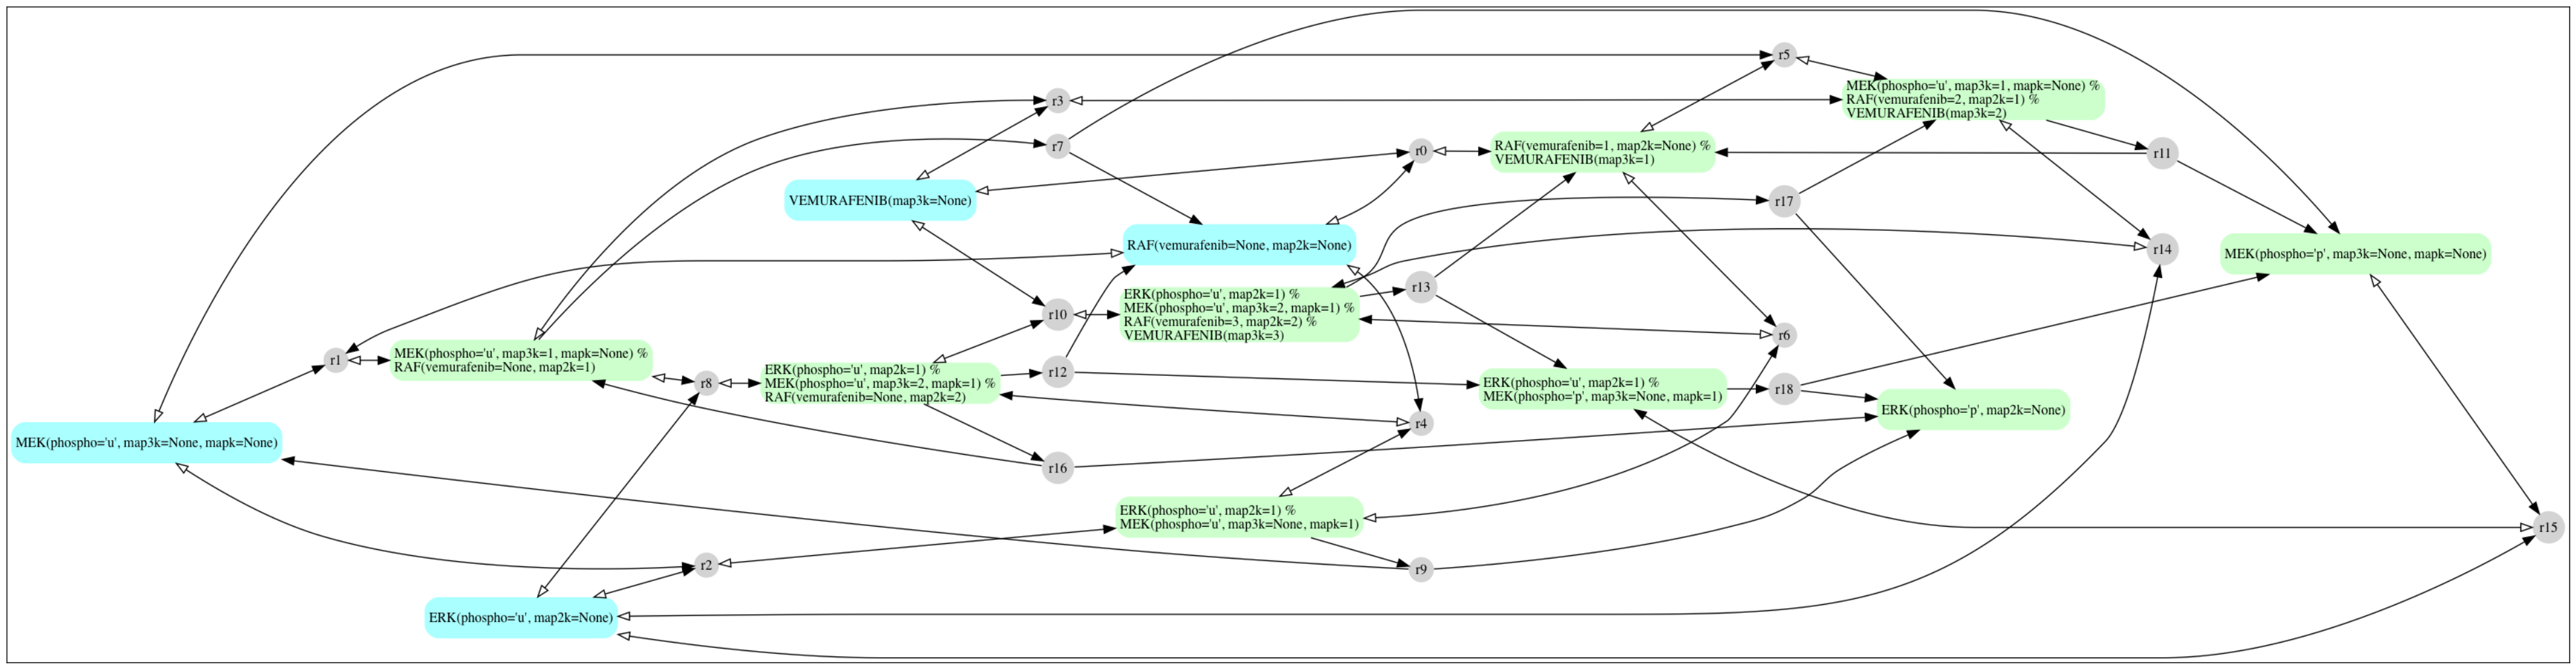

In [16]:
draw_reaction_network(model1_two)

The two-step policy produced a total of 13 molecular species and 19 reactions. ERK now appears in 6 possible forms:
- ERK(phospho='u', map2k=None)
- ERK(phospho='p', map2k=None)
- ERK(phospho='u', map2k=1) % MEK(phospho='u', map3k=None, mapk=1)
- ERK(phospho='u', map2k=1) % MEK(phospho='p', map3k=None, mapk=1)
- ERK(phospho='u', map2k=1) % MEK(phospho='u', map3k=2, mapk=1) % RAF(vemurafenib=None, map2k=2)
- ERK(phospho='u', map2k=1) % MEK(phospho='u', map3k=2, mapk=1) % RAF(vemurafenib=3, map2k=2) % VEMURAFENIB(map3k=3)

This means that our initial description allowed for the possibility of ERK, MEK, RAF and Vemurafenib all simultaneously being in a complex. While the existence of such a complex is not impossible, we can introduce additional assumptions to refine the model.

## Model2: RAF to ERK with specifying context
In this model we introduce additional assumptions (by explicitly making them part of the model definition) to the previous model. In particular, we add additional context on the agents to make causal structure explicit and simplify the model.

### Assembly with two-step policy

In [17]:
tp = trips.process_text('RAF binds Vemurafenib. '
                        'RAF not bound to Vemurafenib phosphorylates MEK. '
                        'Phosphorylated MEK not bound to RAF phosphorylates ERK.')

The INDRA Statements extracted by processing this text are shown below.

In [18]:
tp.statements

[Complex(RAF(), VEMURAFENIB()),
 Phosphorylation(RAF(bound: [VEMURAFENIB, False]), MEK()),
 Phosphorylation(MEK(mods: (phosphorylation), bound: [RAF, False]), ERK())]

We see that some agents are now subject to additional conditions, for instance, `RAF(bound: [VEMURAFENIB, False])` specifies that RAF should not be bound to Vemurafenib in order to phosphorylate MEK.

Let's now assemble the model and generate the reaction network.

In [19]:
pa = PysbAssembler()
pa.add_statements(tp.statements)
pa.make_model(policies='two_step')

<Model 'None' (monomers: 4, rules: 8, parameters: 12, expressions: 0, compartments: 0) at 0x1216faa90>

In [20]:
generate_equations(pa.model)

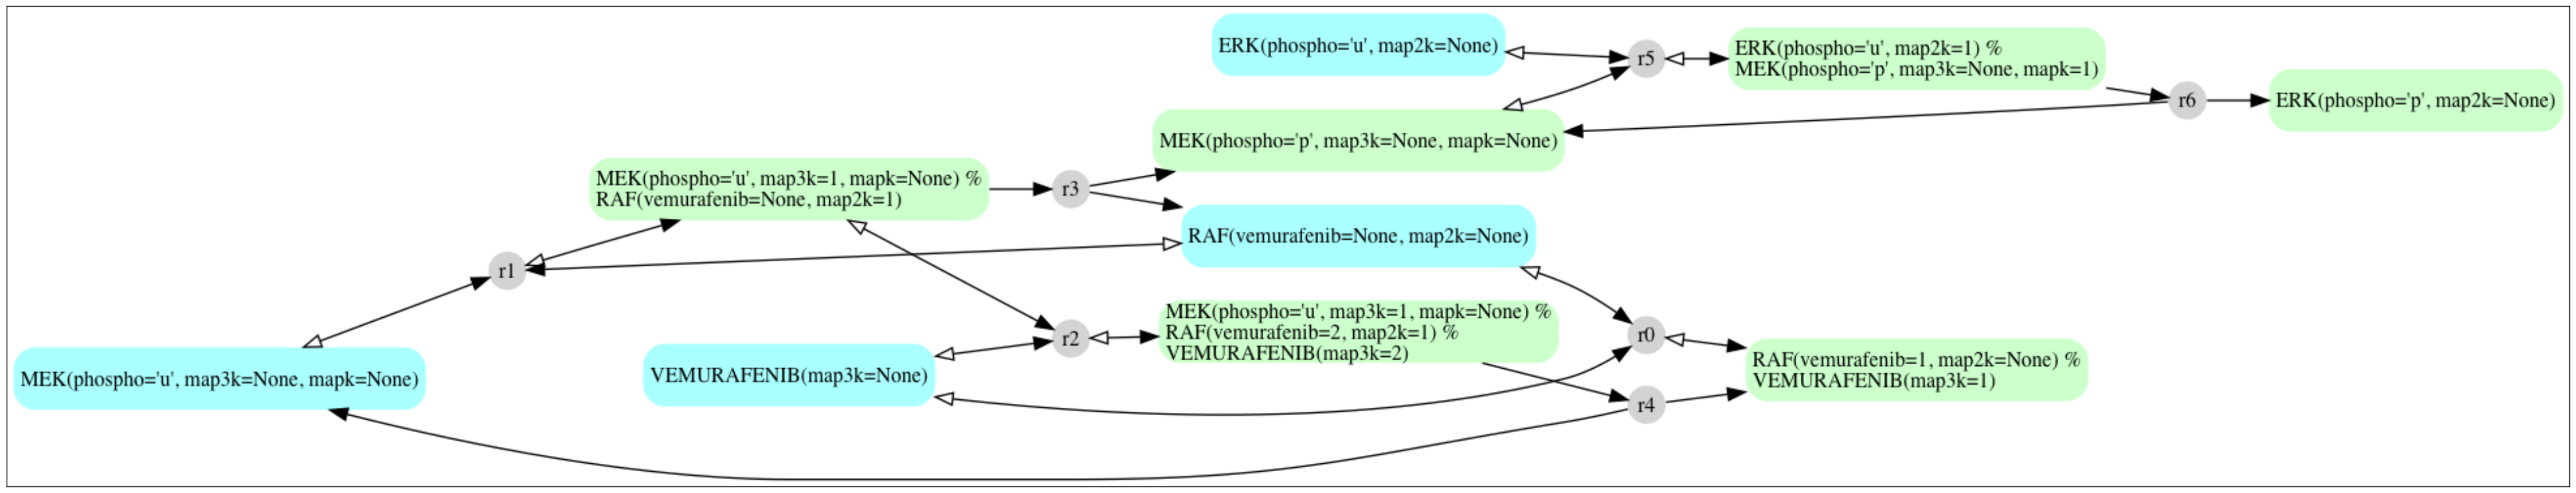

In [21]:
draw_reaction_network(pa.model)

The model is now significantly simpler with a total of 7 reactions down from 19 in the previous model.

### Assembly with one-step policy and Michaelis-Menten rate law

As an alternative to the two-step policy, we can assemble the same model using a simpler, one-step policy.

In [22]:
pa.make_model(policies='one_step')

<Model 'None' (monomers: 4, rules: 4, parameters: 8, expressions: 0, compartments: 0) at 0x1216fa9b0>

In [23]:
generate_equations(pa.model)

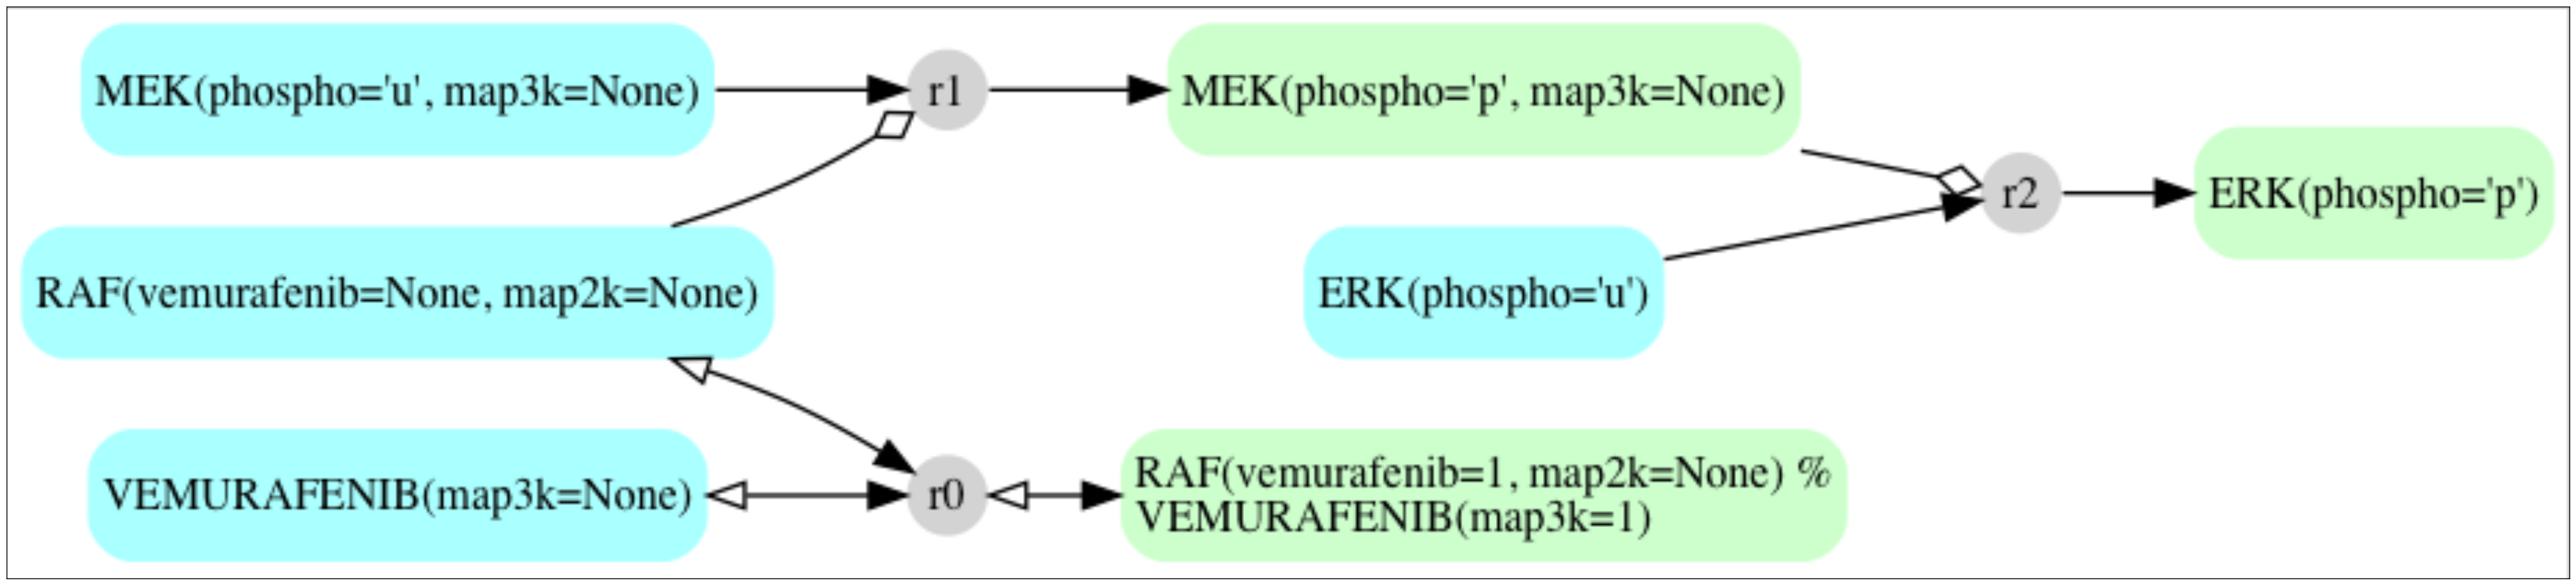

In [24]:
draw_reaction_network(pa.model)

As we see, this model contains 7 individual species with 3 reactions in total.

One issue with the simple one-step policy is that enzymatic catalysis is modeled with pseudo-first order kinetics. Alternatively, we can use a Michaelis-Menten policy in with case both phosphorylation processes are still effectively modeled as one-step but their kinetic rates will account for enzyme saturation. As seen below, the model still retains the same structure as under the one-step policy, only kinetic rates change.

In [25]:
pa.make_model(policies='michaelis_menten')

<Model 'None' (monomers: 4, rules: 4, parameters: 10, expressions: 2, compartments: 0) at 0x117ef4080>

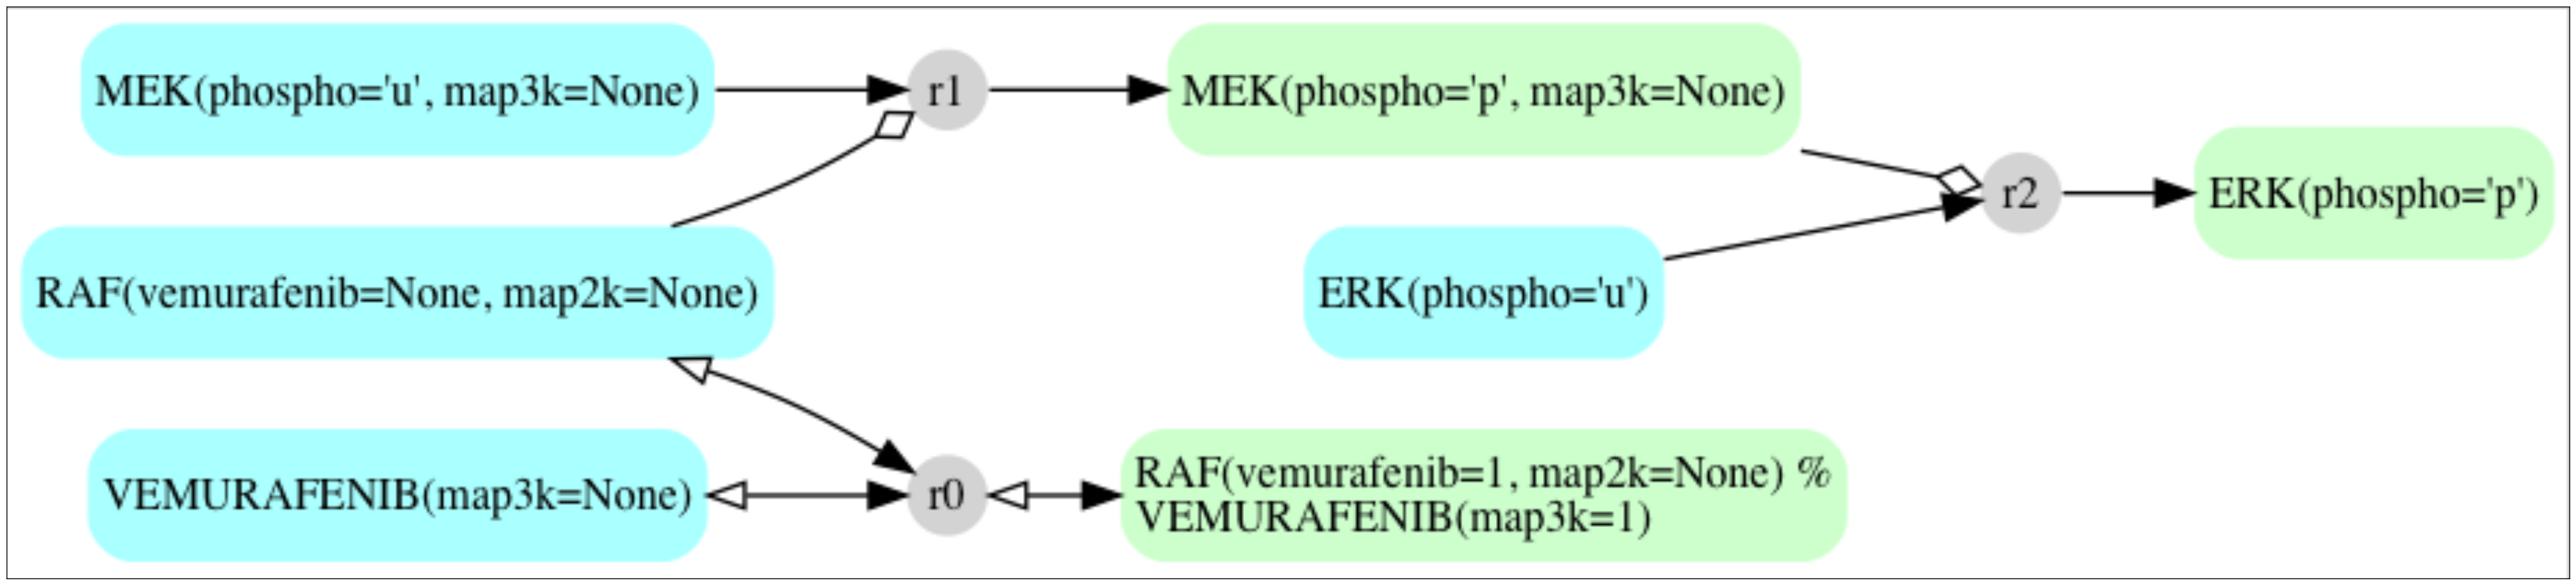

In [26]:
draw_reaction_network(pa.model)